<a href="https://colab.research.google.com/github/UrielMendoza/Wildfire-Burn-Severity-Assessment/blob/main/Script/DL/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --ignore-installed --no-cache-dir -r requirements.txt



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 8.1 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306


In [2]:
!apt-get install -y gdal-bin python3-gdal
!pip install GDAL


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
python3-gdal is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [3]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import pandas as pd
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.utils import class_weight
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_images = []
image_names = glob.glob(r"/content/drive/MyDrive/CG_Tesis_UrielMendoza/metodologia/datos/satelitales/Wildfire Burn Severity Assessment/Training/Image/Post/*.tif")
image_names.sort()
for img_path in image_names:
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      train_images.append(X)

train_images = np.array(train_images)
print(np.mean(train_images))
X_train = train_images
print(X_train.shape)

train_masks = []
image_names = glob.glob(r"/content/drive/MyDrive/CG_Tesis_UrielMendoza/metodologia/datos/satelitales/Wildfire Burn Severity Assessment/Training/Mask/*.tif")
image_names.sort()
for img_path in image_names:
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   train_masks.append(band1)

train_masks = np.array(train_masks)
y_train = train_masks
print(y_train.shape)

y_train_cat = to_categorical(train_masks, num_classes=4)
y_train_cat = y_train_cat.astype(int)
print(y_train_cat.shape)

1283.7584615587612
(690, 256, 256, 3)
(690, 256, 256)
(690, 256, 256, 4)


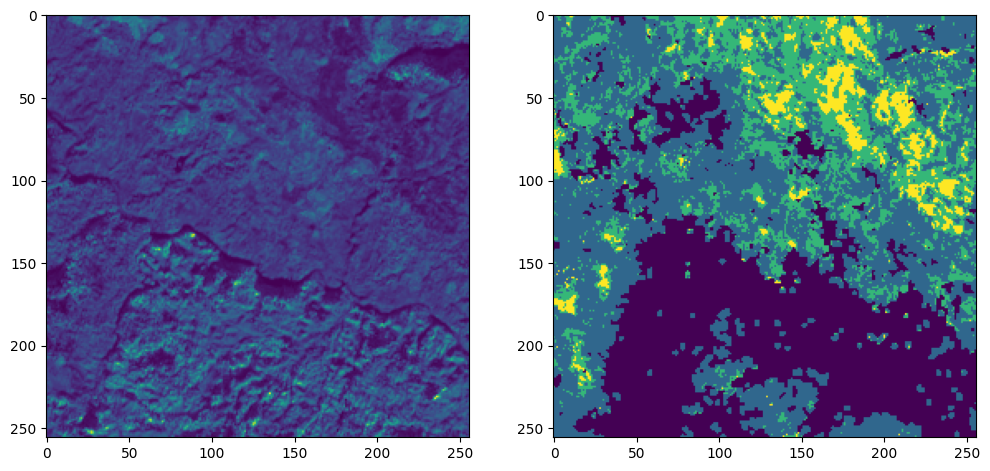

333


In [6]:
#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(train_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((train_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(train_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [7]:
test_images = []
image_names = glob.glob(r"/content/drive/MyDrive/CG_Tesis_UrielMendoza/metodologia/datos/satelitales/Wildfire Burn Severity Assessment/Testing/Image/Post/*.tif")
image_names.sort()
for img_path in image_names:
      tiff_image = gdal.Open(img_path, 0)
      band7 = tiff_image.GetRasterBand(7).ReadAsArray()
      band8 = tiff_image.GetRasterBand(8).ReadAsArray()
      band9 = tiff_image.GetRasterBand(9).ReadAsArray()

      X = np.stack((band9, band8, band7), axis=-1)
      test_images.append(X)

test_images = np.array(test_images)
print(np.mean(test_images))
print(test_images.shape)

test_masks = []
image_names = glob.glob(r"/content/drive/MyDrive/CG_Tesis_UrielMendoza/metodologia/datos/satelitales/Wildfire Burn Severity Assessment/Testing/Mask/*.tif")
image_names.sort()
for img_path in image_names:
   tiff_image = gdal.Open(img_path, 0)
   band1 = tiff_image.GetRasterBand(1).ReadAsArray()
   test_masks.append(band1)

test_masks = np.array(test_masks)
print(np.unique(test_masks))

y_test_cat = to_categorical(test_masks, num_classes=4)
y_test_cat = y_test_cat.astype(int)
print(y_test_cat.shape)
print(np.unique(y_test_cat))

1314.3571367617008
(36, 256, 256, 3)
[0 1 2 3]
(36, 256, 256, 4)
[0 1]


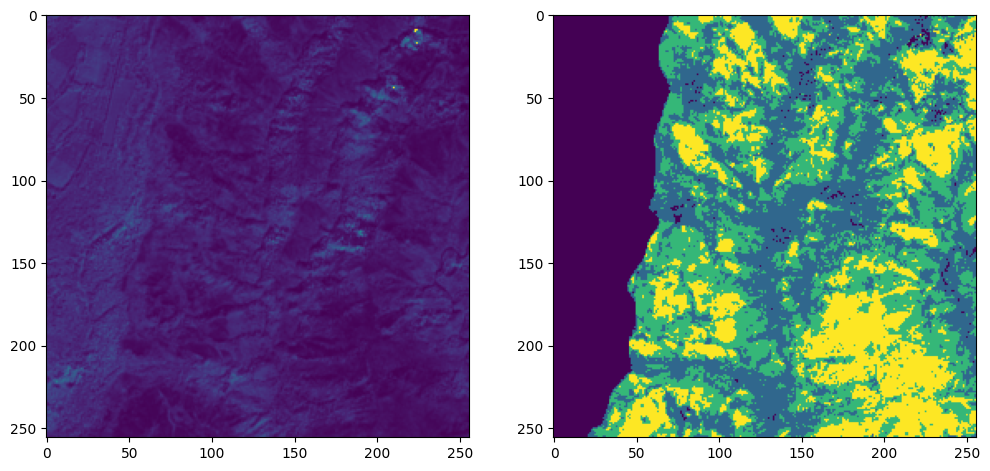

14


In [10]:
# #Sanity check, view few images
image_number = random.randint(0, len(test_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape((test_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(122)
plt.imshow(np.reshape(test_masks[image_number], (256, 256, 1)))
plt.show()
print(image_number)

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, multiply
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def res_conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path


In [12]:
def UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.1, batch_norm=True):

    # network structure
    FILTER_NUM = 16 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

In [13]:
import tensorflow as tf
import tensorflow.keras.backend as K


def categorical_mean_iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)

    # Calculate intersection and union
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection

    # Calculate mean IoU loss
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    mean_iou_loss = 1 - K.mean(iou)

    return mean_iou_loss

In [80]:
import tensorflow as tf

class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        print("Antes de casteo - y_pred dtype:", y_pred.dtype, "Shape:", y_pred.shape)
        print("Antes de casteo - y_true dtype:", y_true.dtype, "Shape:", y_true.shape)

        # Asegurar que ambos sean float32 antes de aplicar argmax
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        # Aplicar argmax a la última dimensión y convertir a int32
        y_true = tf.argmax(y_true, axis=-1)  # Elimina la última dimensión
        y_pred = tf.argmax(y_pred, axis=-1)

        # Convertir a int32
        y_true = tf.cast(y_true, dtype=tf.int32)
        y_pred = tf.cast(y_pred, dtype=tf.int32)

        print("Después de casteo - y_pred dtype:", y_pred.dtype, "Shape:", y_pred.shape)
        print("Después de casteo - y_true dtype:", y_true.dtype, "Shape:", y_true.shape)

        # 🔹 Ahora y_true y y_pred deberían tener forma (batch_size, 256, 256)
        return super().update_state(y_true, y_pred, sample_weight)





In [81]:
# training
def get_model():
    return UNet((256, 256, 3))
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
strategy = tf.distribute.TPUStrategy(tpu)
with strategy.scope():
  model = get_model()
  model.compile(optimizer = 'adam', loss=categorical_mean_iou_loss, metrics = [MyMeanIOU(4)])
# tf.keras.losses.CategoricalCrossentropy()
# categorical_focal_loss(gamma=2.0, alpha=0.25)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 256, 256, 16)   │             64 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 256, 256, 16)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 256, 256, 16)   │             64 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 256, 256, 16)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_45 (Dropout)      │ (None, 256, 256, 16)   │              0 │ activation_96[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 128, 128, 16)   │              0 │ dropout_45[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 128, 128, 32)   │            128 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 128, 128, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ activation_97[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 128, 128, 32)   │            128 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_98             │ (None, 128, 128, 32)   │              0 │ batch_normalization_9… │
│ (Activation)         

 Total params: 1,968,580 (7.51 MB)

 Trainable params: 1,965,628 (7.50 MB)

 Non-trainable params: 2,952 (11.53 KB)

None


In [82]:
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 256, 256, 16)   │             64 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 256, 256, 16)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 256, 256, 16)   │             64 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 256, 256, 16)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_45 (Dropout)      │ (None, 256, 256, 16)   │              0 │ activation_96[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 128, 128, 16)   │              0 │ dropout_45[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 128, 128, 32)   │            128 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 128, 128, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ activation_97[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 128, 128, 32)   │            128 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_98             │ (None, 128, 128, 32)   │              0 │ batch_normalization_9… │
│ (Activation)         

 Total params: 1,968,580 (7.51 MB)

 Trainable params: 1,965,628 (7.50 MB)

 Non-trainable params: 2,952 (11.53 KB)

In [83]:
from keras_flops import get_flops
# Calculae FLOPS
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
print(flops)

ModuleNotFoundError: No module named 'keras_flops'

In [84]:
import numpy as np
import tensorflow as tf

print("Tipo de train_images:", type(train_images))
print("Forma de train_images:", train_images.shape)
print("Tipo de y_train_cat:", type(y_train_cat))
print("Forma de y_train_cat:", y_train_cat.shape)
train_images = train_images / 255.0
batch_size = 8  # Puedes ajustar este valor

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, y_train_cat))
train_dataset = train_dataset.batch(batch_size).shuffle(100).prefetch(tf.data.AUTOTUNE)
print(type(train_dataset))

Tipo de train_images: <class 'numpy.ndarray'>
Forma de train_images: (690, 256, 256, 3)
Tipo de y_train_cat: <class 'numpy.ndarray'>
Forma de y_train_cat: (690, 256, 256, 4)
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [85]:
print("Tipo de y_train_cat:", y_train_cat.dtype)
print("Forma de y_train_cat:", y_train_cat.shape)
print("Tipo de train_images:", train_images.dtype)
print("Forma de train_images:", train_images.shape)


Tipo de y_train_cat: float32
Forma de y_train_cat: (690, 256, 256, 4)
Tipo de train_images: float32
Forma de train_images: (690, 256, 256, 3)


In [86]:
import numpy as np

y_train_cat = np.array(y_train_cat, dtype=np.float32)
train_images = np.array(train_images, dtype=np.float32)

In [87]:
print("Tipo de y_train_cat:", y_train_cat.dtype)
print("Forma de y_train_cat:", y_train_cat.shape)

# Si es int64, conviértelo a int32
if y_train_cat.dtype == tf.int64:
    y_train_cat = tf.cast(y_train_cat, tf.int32)

print("Nuevo tipo de y_train_cat:", y_train_cat.dtype)


Tipo de y_train_cat: float32
Forma de y_train_cat: (690, 256, 256, 4)
Nuevo tipo de y_train_cat: float32


In [88]:
batch_size = 8  # Puedes ajustar este valor

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, y_train_cat))
train_dataset = train_dataset.batch(batch_size).shuffle(100).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_dataset, epochs=50, verbose=1)

Antes de casteo - y_pred dtype: <dtype: 'float32'> Shape: (1, 256, 256, 4)
Antes de casteo - y_true dtype: <dtype: 'float32'> Shape: (1, 256, 256, 4)
Después de casteo - y_pred dtype: <dtype: 'int32'> Shape: (1, 256, 256)
Después de casteo - y_true dtype: <dtype: 'int32'> Shape: (1, 256, 256)
Epoch 1/50
Antes de casteo - y_pred dtype: <dtype: 'float32'> Shape: (None, 256, 256, 4)
Antes de casteo - y_true dtype: <dtype: 'float32'> Shape: (None, 256, 256, 4)
Después de casteo - y_pred dtype: <dtype: 'int32'> Shape: (None, 256, 256)
Después de casteo - y_true dtype: <dtype: 'int32'> Shape: (None, 256, 256)


TypeError: Value passed to parameter 'input' has DataType int64 not in list of allowed values: float16, bfloat16, float32, float64, int32, uint32

In [69]:
# fitting model
import time
start_time = time.time()
history = model.fit(train_images, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=50,
                    validation_split=0.1,
                    # validation_data=(test_images, y_test_cat),
                    shuffle=True)

end_time = time.time()
elapsed_time = end_time - start_time
print("Training time: {:.2f} seconds".format(elapsed_time))

Epoch 1/50
Antes de casteo - y_pred dtype: <dtype: 'float32'>
Antes de casteo - y_true dtype: <dtype: 'float32'>
Después de casteo - y_pred dtype: <dtype: 'int32'>
Después de casteo - y_true dtype: <dtype: 'int32'>


TypeError: Value passed to parameter 'input' has DataType int64 not in list of allowed values: float16, bfloat16, float32, float64, int32, uint32

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
import tensorflow as tf
predicted = np.expand_dims(test_images, 0)
prediction = (model.predict(test_images))
print(prediction.shape)
predicted_img = np.argmax(prediction, axis=3)[:,:,:]
y_test_pred = test_masks
print(predicted_img.shape)
cm = metrics.confusion_matrix(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print(cm, "\n")
print(classification_report(y_test_pred.reshape(-1), predicted_img.reshape(-1), digits=4))

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=4)
IOU_keras.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Mean IoU = ", IOU_keras.result().numpy())
values = np.array(IOU_keras.get_weights()).reshape(4, 4)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0] + values[2,0] + values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1] + values[2,1] + values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2] + values[1,2] + values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3] + values[1,3] + values[2,3])
print("class1 IoU = ", class1_IoU)
print("class2 IoU = ", class2_IoU)
print("class3 IoU = ", class3_IoU)
print("class4 IoU = ", class4_IoU)

m = tf.keras.metrics.Accuracy()
m.update_state(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print('\n', 'Accuracy = ', m.result().numpy())

from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test_pred.reshape(-1), predicted_img.reshape(-1))
print("Kappa:", kappa_score)

In [ ]:
#Randomly check on train images
image_number = random.randint(0, len(train_images)-1)
predicted = np.expand_dims(train_images[image_number], 0)
prediction = (model.predict(predicted))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.reshape((train_images[image_number, :, :, 2]), (256, 256, 1)))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.reshape(train_masks[image_number], (256, 256, 1)))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(np.reshape((predicted_img), (256, 256, 1)))
plt.show()